<a href="https://colab.research.google.com/github/Neelll1705/Eye-Disease-Classification---ML/blob/main/Vision_Transformer_EyeDiseaseClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision transformers
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import ViTForImageClassification, ViTFeatureExtractor
import timm
from tqdm import tqdm

In [ ]:
# Step 1: Upload kaggle.json manually
from google.colab import files
files.upload()  # Upload kaggle.json when prompted

# Step 2: Create kaggle directory and move the json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 3: Download the dataset
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification

# Step 4: Unzip the downloaded file
!unzip eye-diseases-classification.zip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification
License(s): ODbL-1.0
Archive:  eye-diseases-classification.zip
  inflating: dataset/cataract/0_left.jpg  
  inflating: dataset/cataract/103_left.jpg  
  inflating: dataset/cataract/1062_right.jpg  
  inflating: dataset/cataract/1083_left.jpg  
  inflating: dataset/cataract/1084_right.jpg  
  inflating: dataset/cataract/1102_left.jpg  
  inflating: dataset/cataract/1102_right.jpg  
  inflating: dataset/cataract/1115_left.jpg  
  inflating: dataset/cataract/1126_right.jpg  
  inflating: dataset/cataract/112_right.jpg  
  inflating: dataset/cataract/1144_left.jpg  
  inflating: dataset/cataract/1144_right.jpg  
  inflating: dataset/cataract/1164_left.jpg  
  inflating: dataset/cataract/1167_right.jpg  
  inflating: dataset/cataract/119_left.jpg  
  inflating: dataset/cataract/1285_left.jpg  
  inflating: dataset/cataract/1415_left.jpg  
  inflating: dataset/cataract/1

In [ ]:
class EyeDiseaseDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Load image paths and labels
data_dir = "/content/dataset"  # Update this path if necessary
classes = os.listdir(data_dir)
image_paths = []
labels = []

for class_idx, class_name in enumerate(classes):
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, image_name))
        labels.append(class_idx)

# Split the dataset into train and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and dataloaders
train_dataset = EyeDiseaseDataset(train_paths, train_labels, transform=transform)
test_dataset = EyeDiseaseDataset(test_paths, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Load a pre-trained ViT model
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=len(classes))

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

100%|██████████| 106/106 [02:14<00:00,  1.27s/it]


Epoch [1/10], Loss: 0.7367, Accuracy: 71.98%


100%|██████████| 106/106 [02:18<00:00,  1.30s/it]


Epoch [2/10], Loss: 0.2928, Accuracy: 89.83%


100%|██████████| 106/106 [02:19<00:00,  1.32s/it]


Epoch [3/10], Loss: 0.2277, Accuracy: 92.08%


100%|██████████| 106/106 [02:17<00:00,  1.30s/it]


Epoch [4/10], Loss: 0.1753, Accuracy: 93.86%


100%|██████████| 106/106 [02:17<00:00,  1.30s/it]


Epoch [5/10], Loss: 0.1400, Accuracy: 95.55%


100%|██████████| 106/106 [02:17<00:00,  1.30s/it]


Epoch [6/10], Loss: 0.1185, Accuracy: 95.88%


100%|██████████| 106/106 [02:17<00:00,  1.30s/it]


Epoch [7/10], Loss: 0.1210, Accuracy: 95.82%


100%|██████████| 106/106 [02:17<00:00,  1.30s/it]


Epoch [8/10], Loss: 0.0715, Accuracy: 97.63%


100%|██████████| 106/106 [02:18<00:00,  1.31s/it]


Epoch [9/10], Loss: 0.0712, Accuracy: 97.48%


100%|██████████| 106/106 [02:18<00:00,  1.30s/it]

Epoch [10/10], Loss: 0.0542, Accuracy: 98.04%


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total:.2f}%")

100%|██████████| 27/27 [00:16<00:00,  1.62it/s]

Accuracy on test set: 86.85%


In [ ]:
torch.save(model.state_dict(), "eye_disease_vit_model.pth")

100%|██████████| 106/106 [02:20<00:00,  1.33s/it]


Epoch [1/10], Train Loss: 0.0460, Train Acc: 98.31%, Val Loss: 0.0537, Val Acc: 97.96%


100%|██████████| 106/106 [02:17<00:00,  1.29s/it]


Epoch [2/10], Train Loss: 0.0433, Train Acc: 98.55%, Val Loss: 0.0223, Val Acc: 99.26%


100%|██████████| 106/106 [02:17<00:00,  1.30s/it]


Epoch [3/10], Train Loss: 0.0857, Train Acc: 97.01%, Val Loss: 0.0339, Val Acc: 99.07%


100%|██████████| 106/106 [02:17<00:00,  1.30s/it]


Epoch [4/10], Train Loss: 0.0449, Train Acc: 98.55%, Val Loss: 0.1078, Val Acc: 96.11%


100%|██████████| 106/106 [02:17<00:00,  1.29s/it]


Epoch [5/10], Train Loss: 0.0499, Train Acc: 98.78%, Val Loss: 0.0300, Val Acc: 99.07%


100%|██████████| 106/106 [02:17<00:00,  1.30s/it]


Epoch [6/10], Train Loss: 0.0786, Train Acc: 97.36%, Val Loss: 0.0359, Val Acc: 99.44%


100%|██████████| 106/106 [02:17<00:00,  1.29s/it]


Epoch [7/10], Train Loss: 0.0473, Train Acc: 98.31%, Val Loss: 0.0126, Val Acc: 99.81%


100%|██████████| 106/106 [02:17<00:00,  1.30s/it]


Epoch [8/10], Train Loss: 0.0344, Train Acc: 98.87%, Val Loss: 0.0078, Val Acc: 99.81%


100%|██████████| 106/106 [02:17<00:00,  1.30s/it]


Epoch [9/10], Train Loss: 0.0104, Train Acc: 99.53%, Val Loss: 0.0005, Val Acc: 100.00%


100%|██████████| 106/106 [02:16<00:00,  1.29s/it]


Epoch [10/10], Train Loss: 0.0274, Train Acc: 99.41%, Val Loss: 0.0038, Val Acc: 99.81%


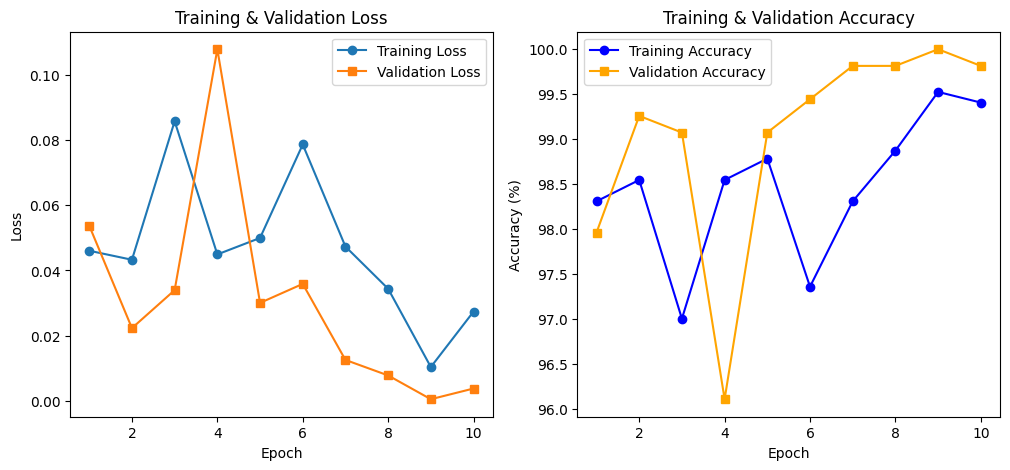

In [ ]:
import matplotlib.pyplot as plt

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10

# Split the training dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create data loader for the validation set
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader: # Use the val_loader here
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct / total)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.2f}%, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")



# Plot training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy", marker='o', color="blue")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy", marker='s', color="orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.show()


In [ ]:
import torch
import numpy as np

# Assuming 'classes' is a list of class names in the order:
# ['glaucoma', 'normal', 'cataract', 'diabetic retinopathy']
# If the order is different, adjust the indices accordingly.

# Initialize lists to store per-class statistics
class_correct = [0] * len(classes)
class_total = [0] * len(classes)

# Evaluate the model to gather per-class predictions
model.eval()  # Set model to evaluation mode

with torch.no_grad():  # Disable gradient calculations
    for images, labels in tqdm(test_loader):  # Assuming you're using your test loader
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Update per-class statistics
        for i in range(len(labels)):  # Iterate over each element in the batch
            label = labels[i].item()  # Get the true label (as a Python integer)
            class_total[label] += 1
            class_correct[label] += (predicted[i].item() == label)

# Print accuracy for specific classes
target_classes = ['glaucoma', 'normal', 'cataract', 'diabetic retinopathy']

print("\nClass-wise Validation Accuracy:")
for target_class in target_classes:
    try:
        index = classes.index(target_class)
        accuracy = (100 * class_correct[index] / class_total[index]) if class_total[index] > 0 else 0
        print(f"Class {target_class}: {accuracy:.2f}%")
    except ValueError:
        print(f"Class {target_class} not found in the dataset.")

100%|██████████| 27/27 [00:16<00:00,  1.68it/s]


Classification Report:
                      precision    recall  f1-score   support

            glaucoma       0.82      0.88      0.85       226
            cataract       0.95      0.86      0.90       214
              normal       0.87      0.88      0.87       201
diabetic_retinopathy       1.00      1.00      1.00       203

            accuracy                           0.90       844
           macro avg       0.91      0.91      0.91       844
        weighted avg       0.91      0.90      0.90       844



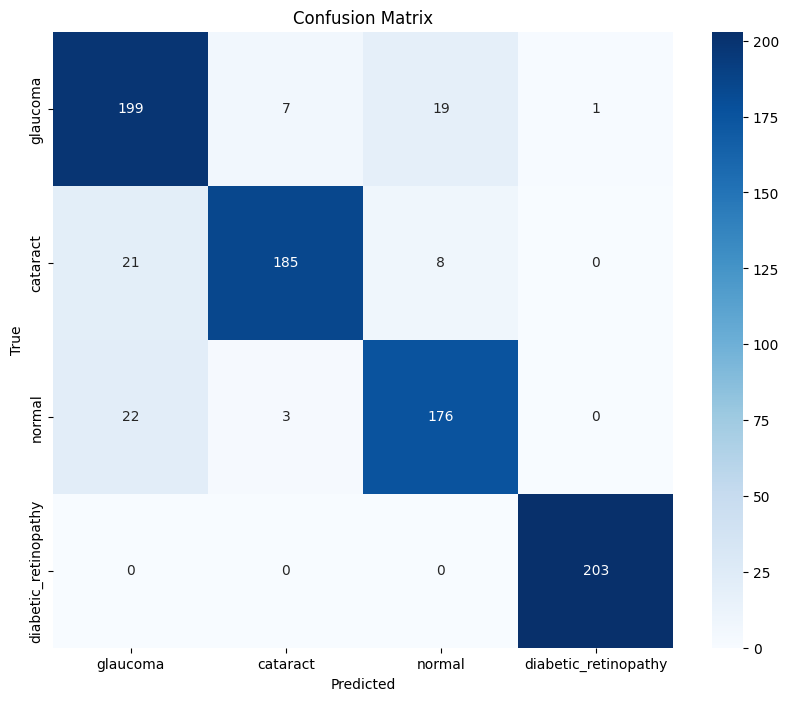

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Initialize lists to store true and predicted labels
all_labels = []
all_predictions = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=classes))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# prompt: write a code for showing classification with .h5 file

import torch
import torch.nn as nn
import timm

# Load the saved model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=4) # Assuming 4 classes
model.load_state_dict(torch.load('eye_disease_vit_model.pth', map_location=device))
model = model.to(device)
model.eval()

# Example usage:
# Assuming 'image' is a preprocessed image tensor of shape (1, 3, 224, 224)
# and 'classes' is a list of class names.

# Example image loading and preprocessing (replace with your actual image loading)
from PIL import Image
from torchvision import transforms
example_image = Image.open("/content/dataset/glaucoma/1020_left.jpg").convert("RGB")  # Replace with your image path
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
image = transform(example_image).unsqueeze(0).to(device)


with torch.no_grad():
    outputs = model(image)
    _, predicted = torch.max(outputs, 1)
    predicted_class_index = predicted.item()

classes = ['glaucoma', 'normal', 'cataract', 'diabetic retinopathy'] # Replace with your actual class names
predicted_class = classes[predicted_class_index]
print(f"Predicted class: {predicted_class}")


Predicted class: glaucoma
